In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
#import matplotlib.pyplot as py
#import seaborn as sns
import statsmodels.api as sm

In [3]:
### Input expression data
gene_expr_body = pd.read_table("/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices/VOOMCounts_CPM5_counts4M_covfree_body_ctrl_onlygenesinmainchr_Jul20.21.txt")
gene_expr_head = pd.read_table("/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices/VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21.txt")

In [4]:
gene_expr_dict = {"head": gene_expr_head.T, "body": gene_expr_body.T}

In [5]:
gene_expr_dict["body"].mean(axis=0)

FBgn0052350     4.672873
FBgn0024733    12.695032
FBgn0040372     6.000547
FBgn0023536     4.011901
FBgn0023537     7.338484
                 ...    
FBgn0031313     5.911469
FBgn0031309     4.745208
FBgn0031305     4.759798
FBgn0016926     7.339688
FBgn0003310     5.703859
Length: 5533, dtype: float64

In [6]:
X_head = (gene_expr_dict["head"] - gene_expr_dict["head"].mean()) / np.sqrt(gene_expr_dict["head"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_head_corr = oa.fit(X_head)

X_body = (gene_expr_dict["body"] - gene_expr_dict["body"].mean()) / np.sqrt(gene_expr_dict["body"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_body_corr = oa.fit(X_body)

gene_expr_OAS_corr = {"head": regularized_head_corr, 
                      "body": regularized_body_corr}

In [7]:
g = load_graph("VOOMCounts_CPM5_counts4M_covfree_body_ctrl_onlygenesinmainchr_Jul20.21_regularized_correlations_precisions_pvalues_cutoff_1e-6.xml.gz")

In [8]:
g_significant = GraphView(g, g.get_total_degrees(g.get_vertices()) > 1 )
g_significant = GraphView(g_significant, g_significant.get_total_degrees(g_significant.get_vertices()) > 1 )
g_significant

<GraphView object, undirected, with 3510 vertices and 323978 edges, 1 internal vertex property, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff73cb028e0, at 0x7ff73d143d30>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff73cb028e0, at 0x7ff73d143d00>, False), at 0x7ff73cb028e0>

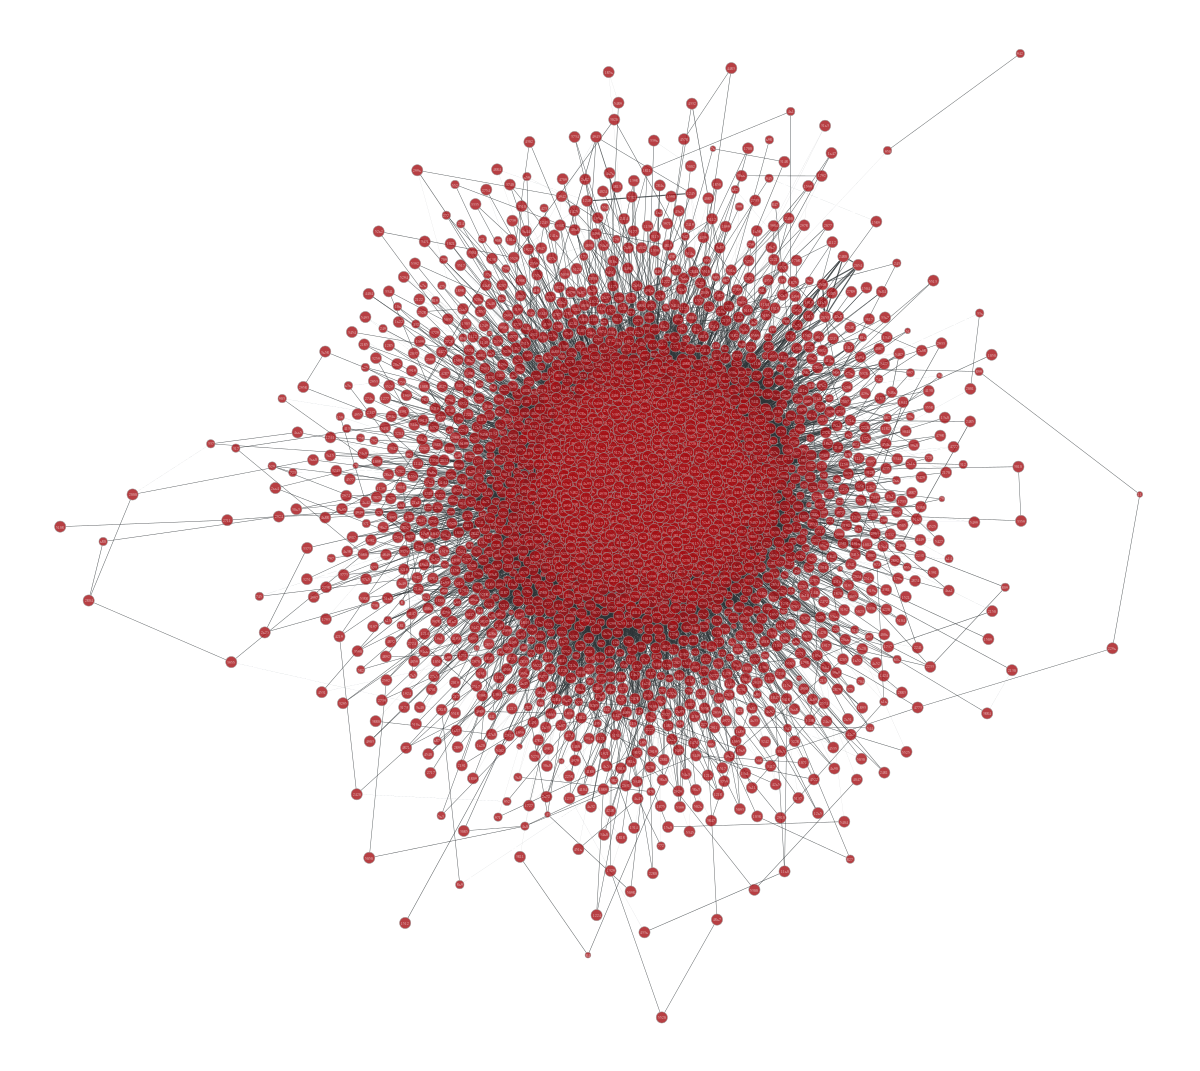

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff73cb028e0, at 0x7ff73cb2b880>

In [9]:
graph_draw(g_significant, vertex_text=g.vertex_index, edge_pen_width=g.edge_properties["correlation"])

In [10]:
gf = g.copy()

In [11]:
# Filtering edges
pval = gf.edge_properties["pvalue"]
corr = gf.edge_properties["correlation"]
sign = gf.new_ep("bool", True)
sign.a = np.array(corr.a > 0.3)
gf.set_edge_filter(sign)
gf.purge_edges()

# Keeping largest component
comp, hist = label_components(gf)
main_component = gf.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
gf.vertex_properties["main_component"] = main_component
gf.set_vertex_filter(main_component)
gf.purge_vertices()

In [12]:
N = len(gf.get_vertices())
Et = (N * N - N)/2
E = len(gf.get_edges())
E/Et

0.04119683920802628

In [13]:
gf

<Graph object, undirected, with 1610 vertices and 53360 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d143c70>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d155ee0>, False), at 0x7ff73d15a550>

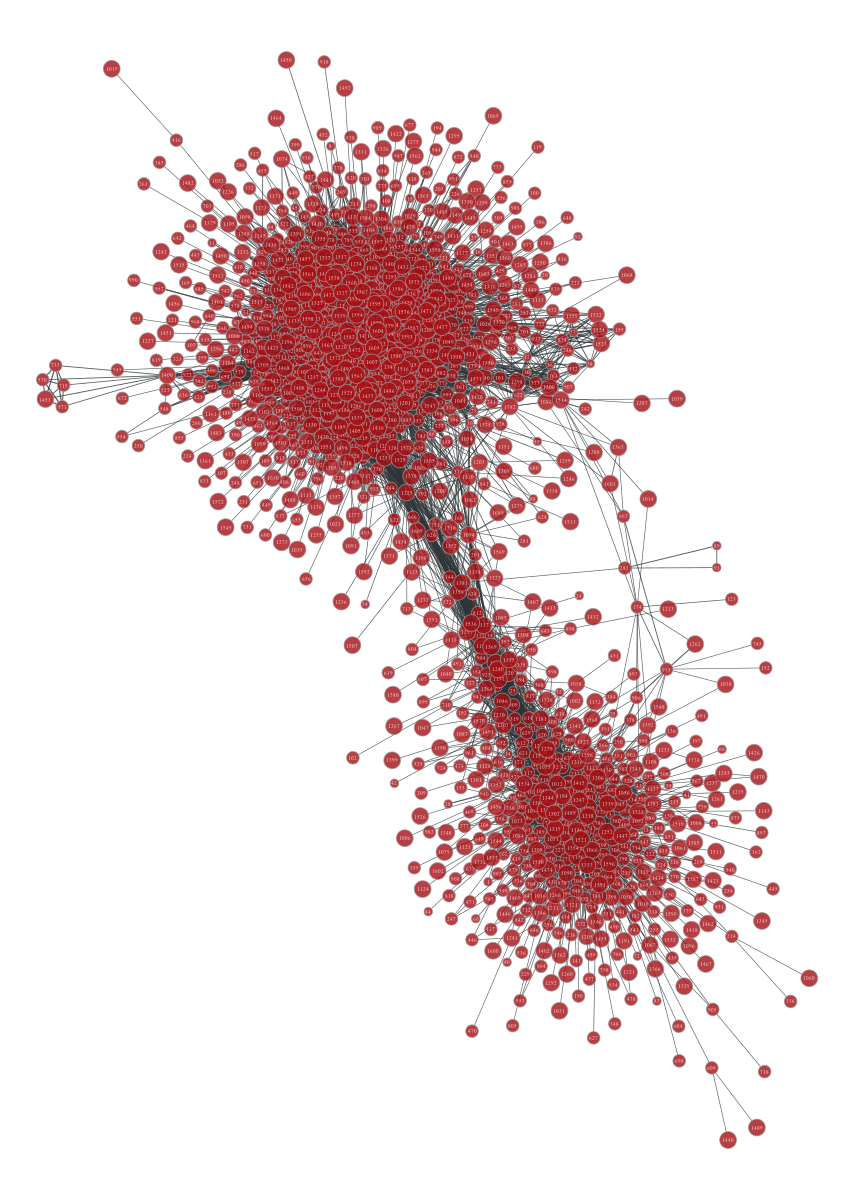

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff73d15a550, at 0x7ff73cb2bb20>

In [14]:
graph_draw(gf, vertex_text=gf.vertex_index, edge_pen_width=gf.edge_properties["correlation"])

In [40]:
gene_list = []
for i in gf.vertex_properties['genes']:
    gene_list.append(i)
gene_expr_body.T[gene_list].T.to_csv("../data/VOOMCounts_CPM5_counts4M_covfree_body_ctrl_onlygenesinmainchr_Jul20.21_filtered_by_correlation-0.3.csv")

In [17]:
corr = gf.edge_properties["correlation"]
n_trials = 10
state_nn_min_list = []
for i in range(n_trials):
    print(i)
    #state_min = minimize_blockmodel_dl(gf, state_args=dict(recs=[corr],
    #                                                       rec_types=["real-normal"]))
    state_min = minimize_blockmodel_dl(gf)
    state_nn_min_list.append(state_min)

0
1
2
3
4
5
6
7
8
9


In [18]:
state_nn_min_list

[<BlockState object with 1610 blocks (45 nonempty), degree-corrected, for graph <Graph object, undirected, with 1610 vertices and 53360 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d143c70>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d155ee0>, False), at 0x7ff73d15a550>, at 0x7ff73d16f370>,
 <BlockState object with 1610 blocks (42 nonempty), degree-corrected, for graph <Graph object, undirected, with 1610 vertices and 53360 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d143c70>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d155ee0>, False), at 0x7ff73d15a550>, at 0x7ff73d15ddf0>,
 <BlockState object with

In [19]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret_nn = []
state_nn_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_nn_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_nn_mcmc_list.append(state)
        ret_nn.append(x)

0


/Genomics/grid/users/damelo/.conda/envs/gt/lib/python3.9/site-packages/graph_tool/inference/blockmodel.py:383: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


1
2
3
4
5
6
7
8
9


In [23]:
description_lenghts = np.zeros(n_trials)
for j in range(n_trials):
    description_lenghts[j] = state_nn_mcmc_list[j].entropy()
min_index = np.argmin(description_lenghts)
description_lenghts

array([105157.37118558, 105171.75233015, 105114.19841313, 105091.462195  ,
       105193.81707512, 105111.8666425 , 105145.19024058, 105127.7564788 ,
       105145.255047  , 105199.51723251])

In [24]:
state_min_nn = state_nn_mcmc_list[min_index]

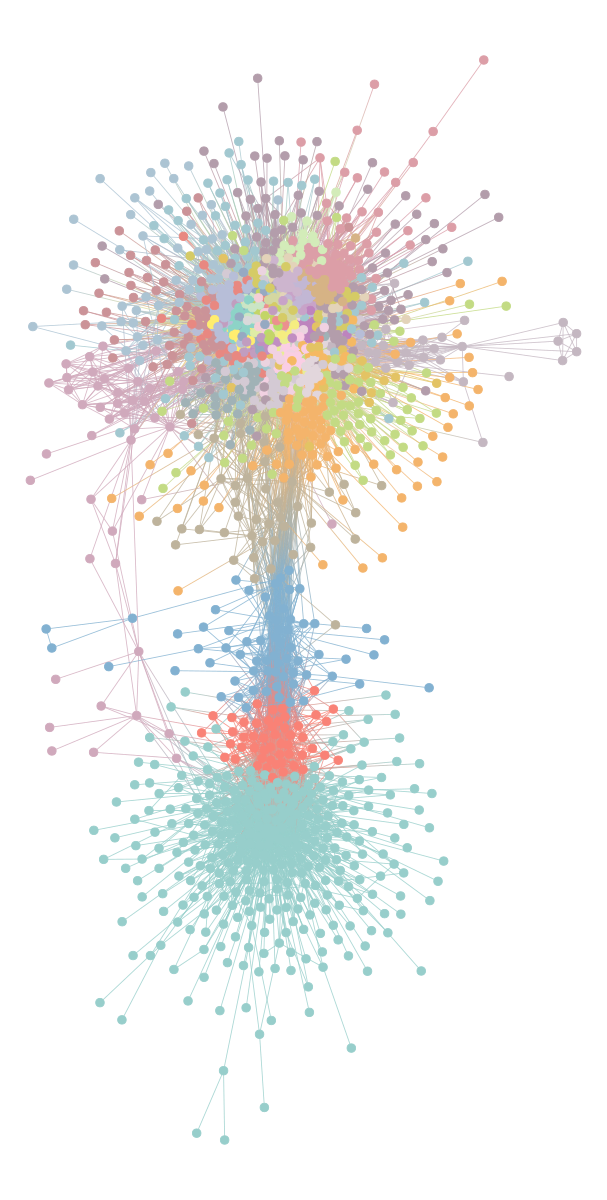

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff73d15a550, at 0x7ff639de2fa0>

In [25]:
state_min_nn.draw()

In [28]:
def create_Block_df(g, state):
    genes = g.vertex_properties["genes"]
    corr = g.edge_properties["correlation"]
    block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'Block'))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [corr] )[:,2]))
        line.append(state.get_blocks()[v])
        block_df.loc[v] = line
    return block_df

In [29]:
block_df = create_Block_df(gf, state_min_nn)
block_df
block_df.to_csv("../data/1610genes-non_hierarchical_sbm-fit_body_df.csv")

In [30]:
n_trials = 10
state_min_list = []
for i in range(n_trials):
    print(i)
    #state_min = minimize_nested_blockmodel_dl(gf, state_args=dict(recs=[corr],
    #                                                              rec_types=["real-normal"]))
    state_min = minimize_nested_blockmodel_dl(gf)
    state_min_list.append(state_min)

0
1
2
3
4
5
6
7
8
9


In [31]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret = []
state_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_mcmc_list.append(state)
        ret.append(x)

0
1
2
3
4
5
6
7
8
9


In [32]:
description_lenghts = np.zeros(n_trials)
for j in range(n_trials):
    description_lenghts[j] = state_mcmc_list[j].entropy()
min_index = np.argmin(description_lenghts)
state_min = state_mcmc_list[min_index]
description_lenghts

array([103516.01081079, 103497.54399752, 103593.80019823, 103563.43264807,
       103543.1224962 , 103565.36296223, 103558.6741858 , 103549.45129447,
       103476.77541526, 103466.15299642])

In [33]:
#state_min.
levels = state_min.get_levels()
len(levels)

12

In [34]:
levels = state_min.get_levels()
for s in levels:
    print(s)

<BlockState object with 1573 blocks (68 nonempty), degree-corrected, for graph <Graph object, undirected, with 1610 vertices and 53360 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d143c70>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff73d15a550, at 0x7ff73d155ee0>, False), at 0x7ff73d15a550>, at 0x7ff639ac1d00>
<BlockState object with 64 blocks (15 nonempty), for graph <Graph object, undirected, with 1573 vertices and 1257 edges, at 0x7ff639ae9820>, at 0x7ff639ae9130>
<BlockState object with 17 blocks (5 nonempty), for graph <Graph object, undirected, with 64 vertices and 87 edges, at 0x7ff639aee160>, at 0x7ff639ae9b20>
<BlockState object with 4 blocks (2 nonempty), for graph <Graph object, undirected, with 17 vertices and 11 edges, at 0x7ff639af0580>, at 0x7ff639aee070>
<BlockState object with 2 blocks (1 nonempty)

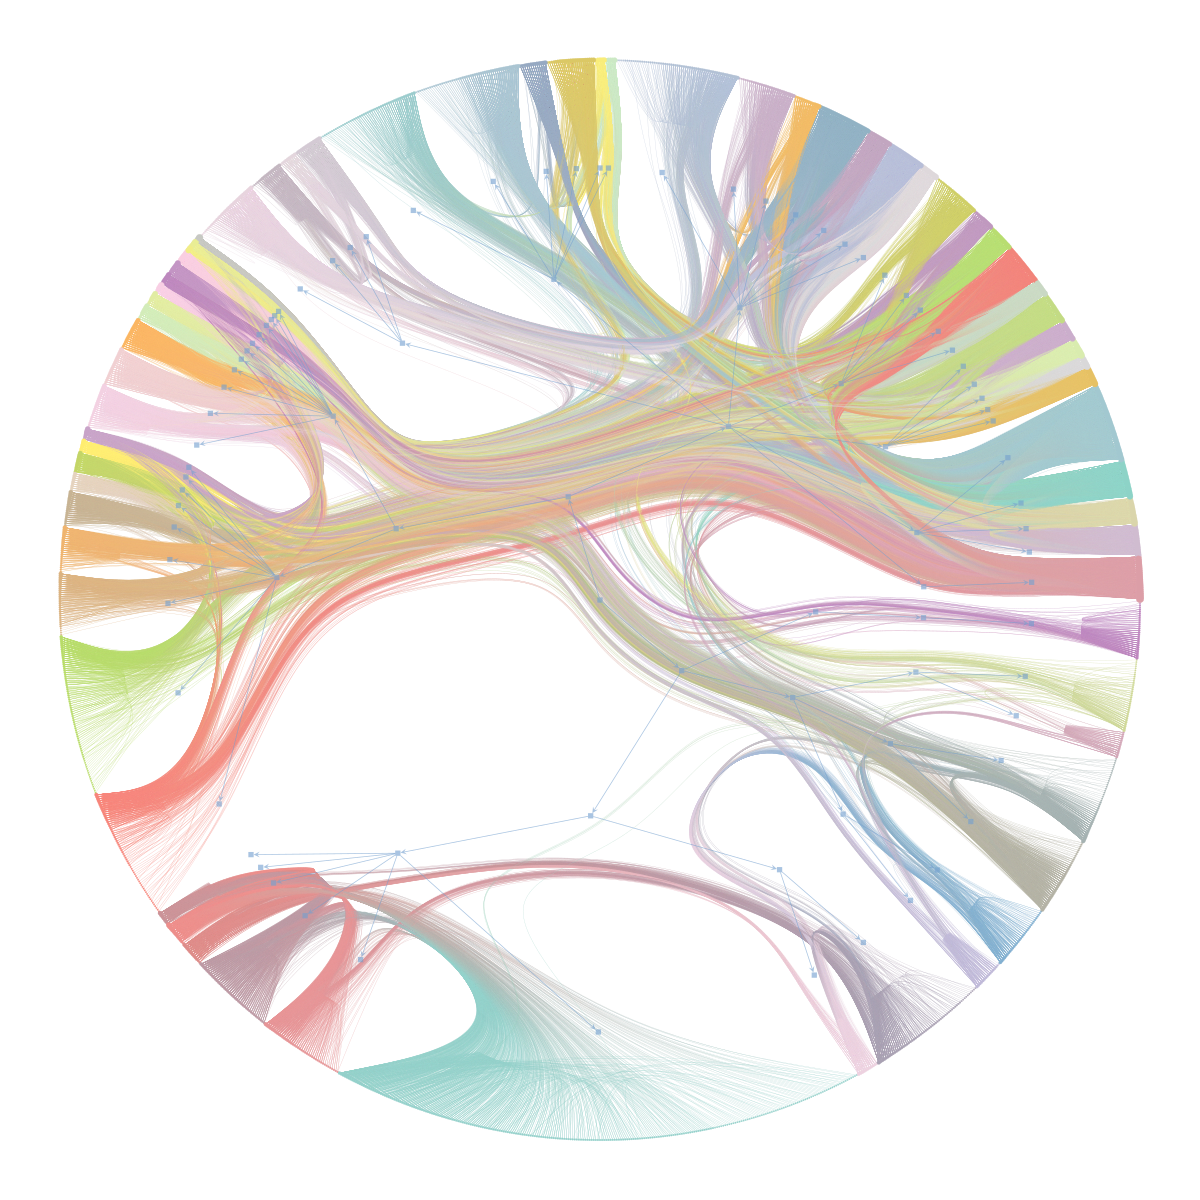

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff73d15a550, at 0x7ff639dc9460>,
 <Graph object, directed, with 1701 vertices and 1700 edges, at 0x7ff639dc3c40>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff639dc3c40, at 0x7ff5a6a381f0>)

In [35]:
state_min.draw()

In [ ]:
sns.histplot(state_min_non_nested.b.a)

In [ ]:
state_min.draw(output="../plots/5524genes-hsbm-fit.png")


In [36]:
def get_group(x, state):
    levels = state.get_levels()
    n_levels = 5#len(levels)
    r = np.zeros(n_levels)
    r[0] = levels[0].get_blocks()[x]
    for i in range(1, n_levels):
        r[i] = levels[i].get_blocks()[r[i-1]]
    r = r.astype(int)
    return r
def create_nestedBlock_df(g, state):
    genes = g.vertex_properties["genes"]
    correlation = g.edge_properties["correlation"]
    nested_block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'B1', "B2", "B3", "B4", "B5"))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [correlation] )[:,2]))
        [line.append(i) for i in get_group(v, state)]
        nested_block_df.loc[v] = line
    return nested_block_df

In [37]:
nested_block_df = create_nestedBlock_df(gf, state_min)

In [38]:
nested_block_df

Gene Degree    E_corr    B1  B2  B3 B4 B5
0     FBgn0024733    284  0.429642  1436  48   9  0  0
1     FBgn0040372      3  0.324167  1224  42   1  3  0
2     FBgn0023537      5  0.308728   615   2   9  0  0
3     FBgn0015799     10  0.324003  1224  42   1  3  0
4     FBgn0015288     26  0.347842   615   2   9  0  0
...           ...    ...       ...   ...  ..  .. .. ..
1605  FBgn0053126    128  0.340397   743  63   9  0  0
1606  FBgn0040723    109  0.390158  1268  35   9  0  0
1607  FBgn0031313     64  0.324078   473  29  14  0  0
1608  FBgn0031305     13  0.306431   473  29  14  0  0
1609  FBgn0016926      3  0.313833   119  37   8  3  0

[1610 rows x 8 columns]

In [39]:
nested_block_df.to_csv("../data/1610genes-Control_Body-hsbm-fit_df.csv")